![Gaming Panorama](warrank.jpg)

---
# WarRank

### A Bayesian Warmachine/Hordes player rating system using Microsoft TrueSkill

### The Plaid Mentat

##### Based on RedRank by Kevin Beam
---

In [1]:
from io import StringIO
from functools import reduce
from itertools import zip_longest
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

plt.style.use('seaborn')

---
## Game Results

### The game results are entered in a [Google Sheet](https://docs.google.com/spreadsheets/d/1sOV2dhdXgPbWmacQRWN1hEVUBWzfpy5c6T5W-qowGoY/edit#gid=0) and are pulled in dynamically when this notebook is run.
---

In [2]:
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1837mBr2O_siclsJoDzS-WniDv14FjPo0ke9VzZ7zjvs&output=csv&gid=0')
csv_data = r.content.decode('utf-8')
games = pd.read_csv(StringIO(csv_data), index_col=0)
games.fillna('-')

,Daniel C.,Ian M.,Oliver D.,William R.,Garrett B.,Harry H.,Trevor S.,Kodi D.,Cidne S.,Dylan S.,Brooke R.,Bryon V.,Keagan A.
Date,,,,,,,,,,,,,
7/17/2016,0,-,1,-,-,-,-,-,-,-,-,-,-
7/17/2016,0,-,-,-,-,-,-,-,-,-,-,-,1
7/17/2016,0,1,-,-,-,-,-,-,-,-,-,-,-
7/17/2016,-,1,-,-,0,-,-,-,-,-,-,-,-
7/17/2016,-,1,0,-,-,-,-,-,-,-,-,-,-
7/17/2016,-,-,1,-,-,-,-,-,-,-,-,-,0
7/24/2016,1,-,-,0,-,-,-,-,-,-,-,-,-
7/31/2016,-,1,-,0,-,-,-,-,-,-,-,-,-
7/31/2016,1,-,-,0,-,-,-,-,-,-,-,-,-


---

# TrueSkill

### Use Microsoft TrueSkill to rate the players

### Conservative estimate of player strength -- there is a 99% chance your rating is above this level

---

In [3]:
import math
from functools import partial
from scipy.stats import norm
import seaborn as sns; sns.set()

from trueskill import TrueSkill
from datetime import datetime

In [4]:
ts = TrueSkill(mu=500.0, sigma=500.0/3,
               beta=500.0/6, tau=500.0/300, 
               draw_probability=0.01, backend='scipy')

In [5]:
initial_ratings = {n: ts.create_rating() for n in games.columns}

In [6]:
def rate_game(ratings, game):
    game = game.dropna()
    rating_groups = [(ratings[n],) for n in game.index]
    ranks = game.rank(ascending=False).values.astype(int)
    game_ratings = {p: r[0] for p, r in zip(game.index, ts.rate(rating_groups, ranks))}
    return {**ratings, **game_ratings}

In [7]:
current_ratings = initial_ratings
new_ratings = None
postgame_ratings = [(None, None, initial_ratings)]
gamedates = []
for date, game in games.iterrows():
    current_ratings = rate_game(current_ratings, game)
    postgame_ratings.append((date, game, current_ratings))
    gamedates.append(datetime.strptime(date,'%m/%d/%Y'))
gamedates.insert(0,gamedates[0])

In [8]:
date, game, ratings = postgame_ratings[-1]
ordinal_ratings = pd.DataFrame([max(0, round(r.mu - 3*r.sigma, 0)) for _, r in ratings.items()], [n for n, _ in ratings.items()], columns=['Rating'])
ordinal_ratings = ordinal_ratings.sort_values(by='Rating', ascending=False)
ordinal_ratings

,Rating
Ian M.,544.0
Daniel C.,518.0
Trevor S.,404.0
Brooke R.,395.0
Garrett B.,374.0
Kodi D.,364.0
Dylan S.,353.0
Oliver D.,347.0
Cidne S.,347.0
Harry H.,294.0


---
## Player rating estimate curves

### Location of the peak indicates the mean player strength estimate; the width of curve is the uncertainty of the estimate.
---

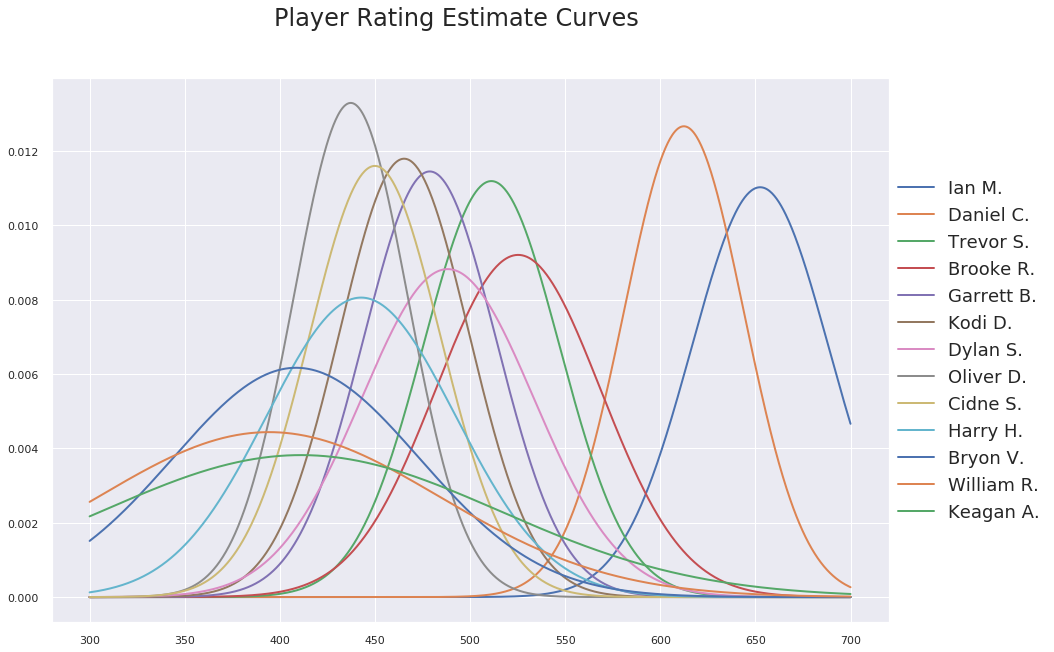

In [9]:
def sortThird(val): 
    return val[2]

sorted_ratings = []
minmu = maxmu = 500
delta = 20
for n, r in ratings.items():
    sorted_ratings.append([n, r, max(0, r.mu - 3*r.sigma)])
    if r.mu > maxmu:
        maxmu = r.mu
    if r.mu < minmu:
        minmu = r.mu
sorted_ratings.sort(key = sortThird, reverse = True)
maxmu = int((maxmu+delta)/100+1)*100
minmu = int((minmu-delta)/100)*100

f = plt.figure(figsize=(15,10))
f.suptitle('Player Rating Estimate Curves', fontsize=24)
x = np.linspace(minmu,maxmu,1000)
for n, r, m in sorted_ratings:
    plt.plot(x, norm.pdf(x, loc=r.mu, scale=r.sigma), label=n, linewidth=2)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), fontsize=18)

---
## Pairwise win probability

### The heatmap shows the probability that the player on the vertical axis beats each player along the horizonal axis.
---

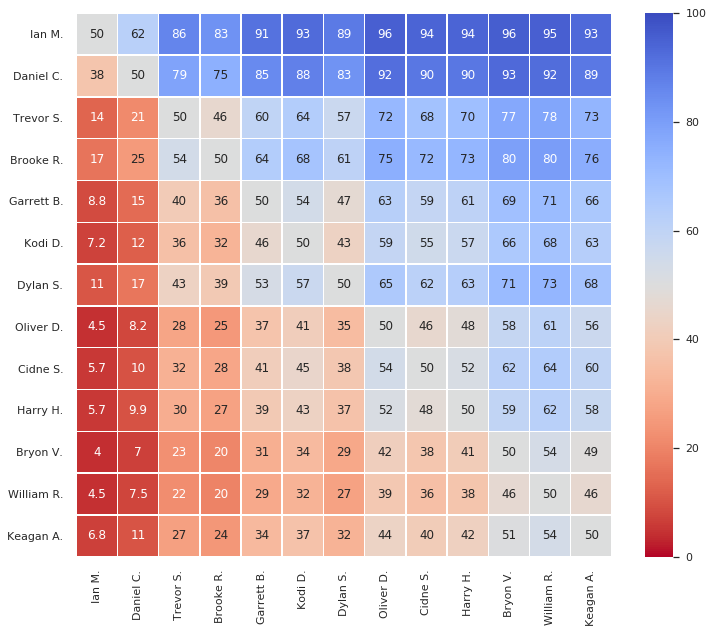

In [10]:
def win_prob(p1, p2):
    delta_mu = p1.mu - p2.mu
    sum_sigma = p1.sigma ** 2 + p2.sigma ** 2
    return ts.cdf(delta_mu / math.sqrt(2*ts.beta*ts.beta + sum_sigma))
        
players=[item[0] for item in sorted_ratings]
wp = {n: [100*win_prob(ratings[o], ratings[n]) for o in players] 
      for n in players}
wp_df = pd.DataFrame(wp, index=players)

plt.subplots(figsize=(12,10))
sns.heatmap(wp_df, vmin=0, vmax=100, annot=True, linewidths=0.5, cmap='coolwarm_r')

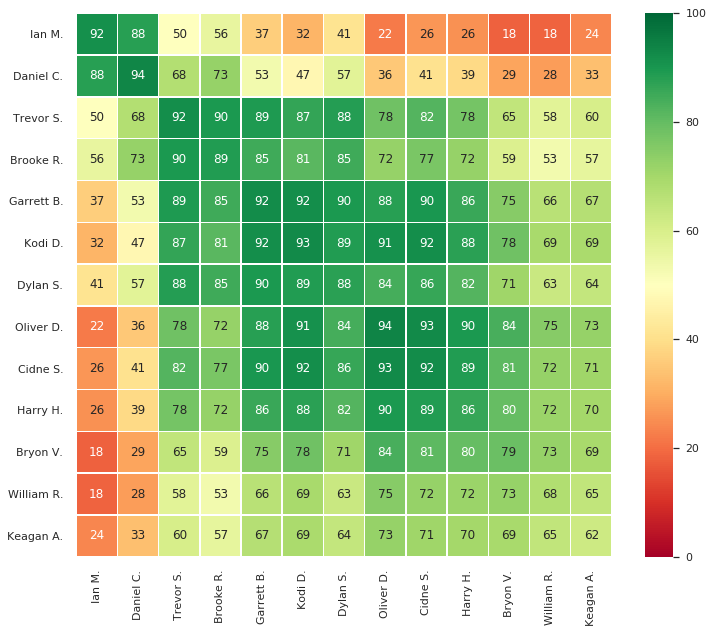

In [17]:
players=[item[0] for item in sorted_ratings]
gq = {n: [100*ts.quality_1vs1(ratings[o], ratings[n]) for o in players] 
      for n in players}
gq_df = pd.DataFrame(gq, index=players)

plt.subplots(figsize=(12,10))
sns.heatmap(gq_df, vmin=0, vmax=100, annot=True, linewidths=0.5, cmap='RdYlGn')

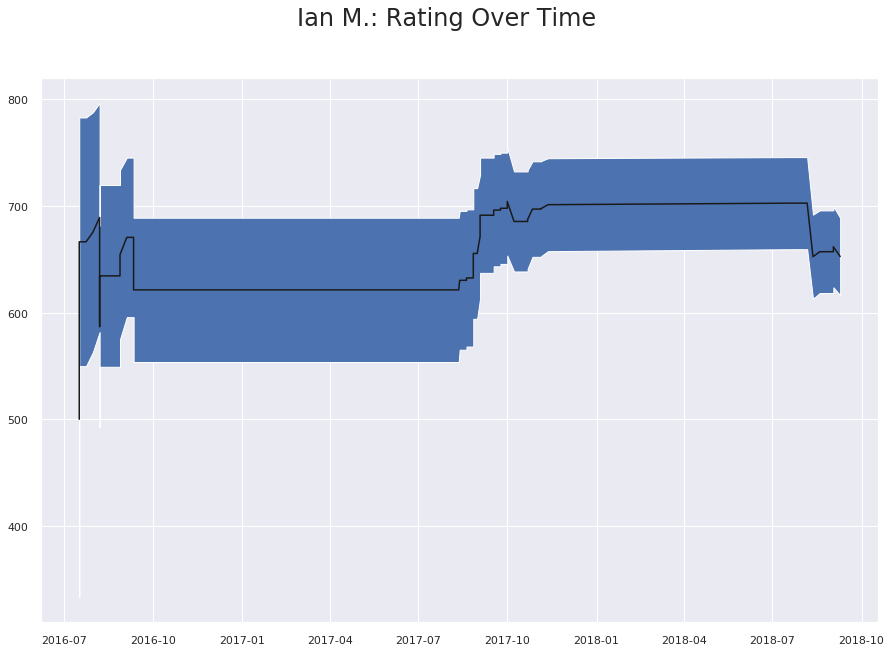

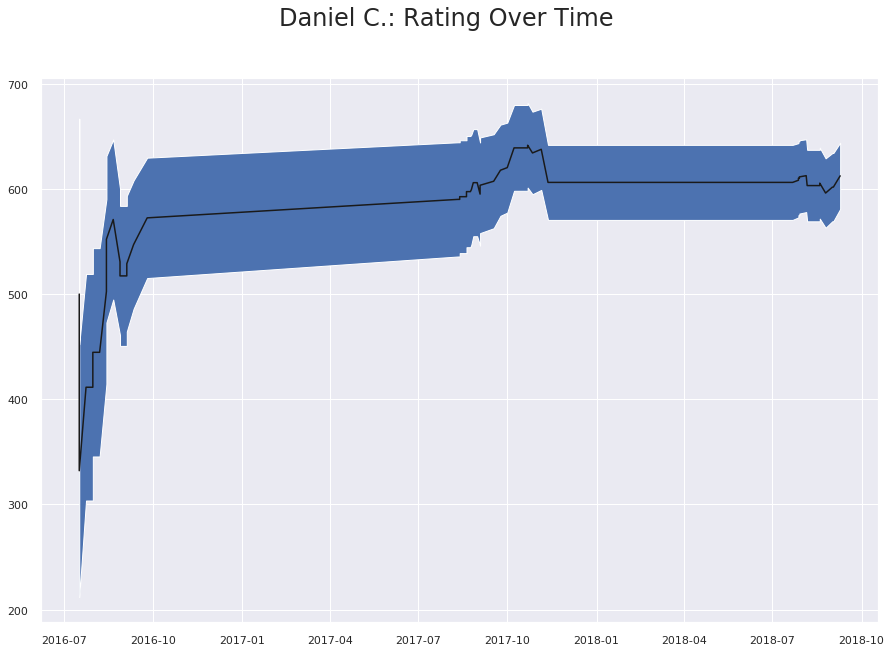

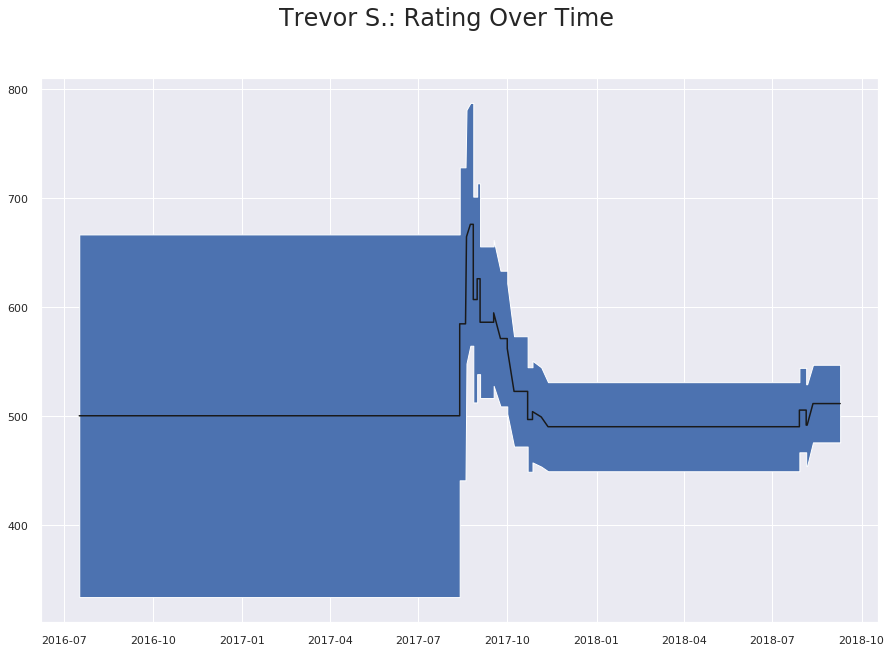

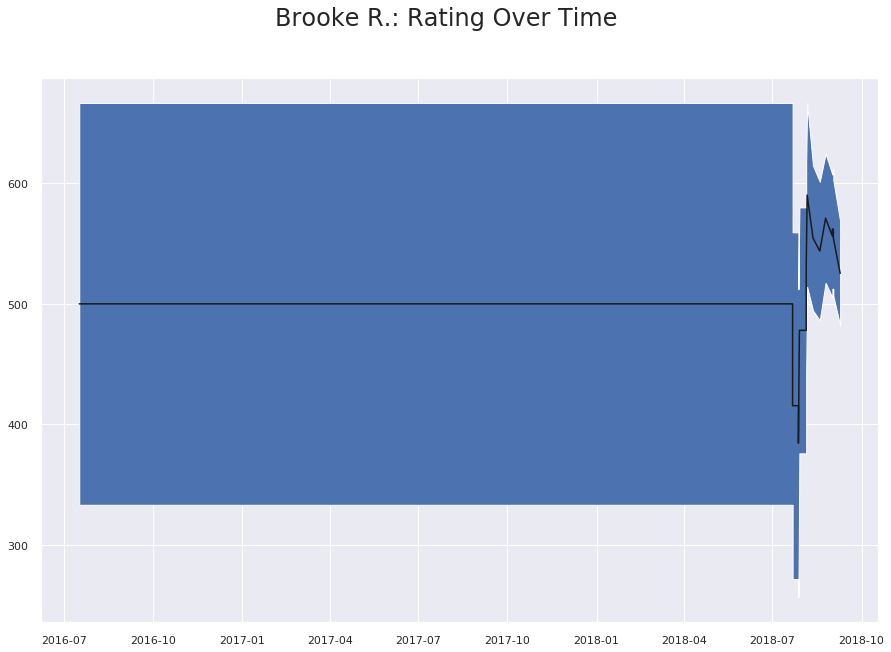

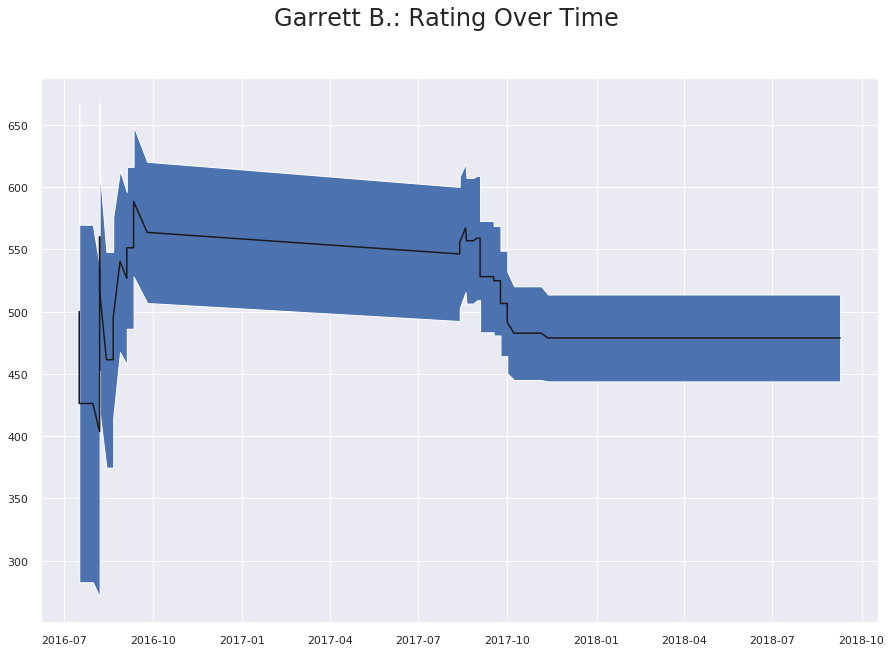

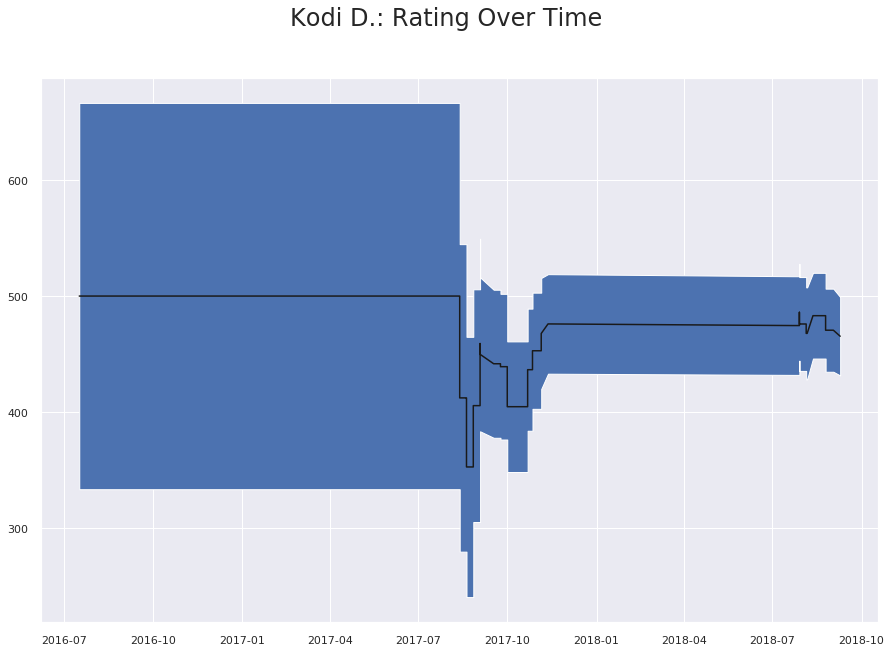

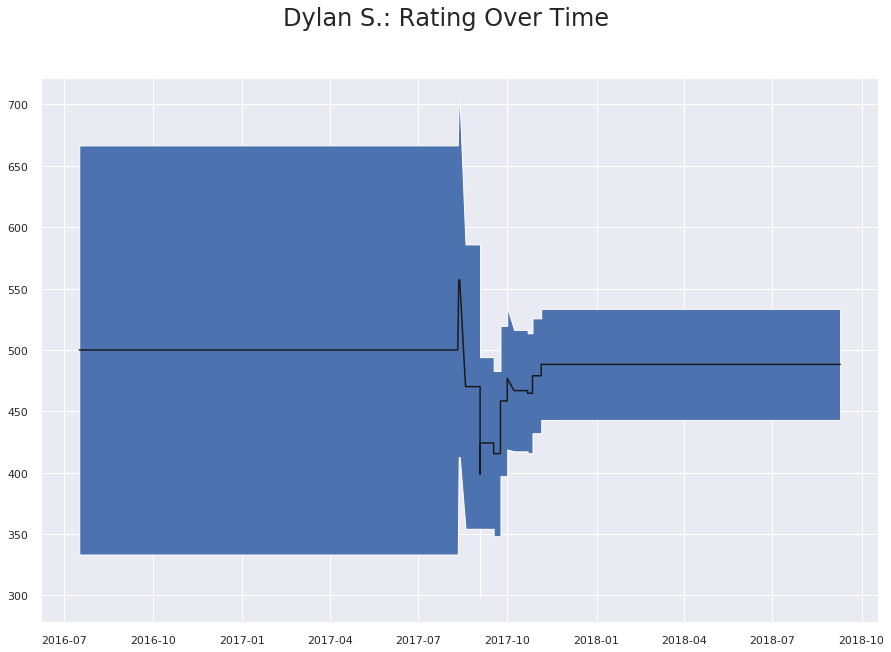

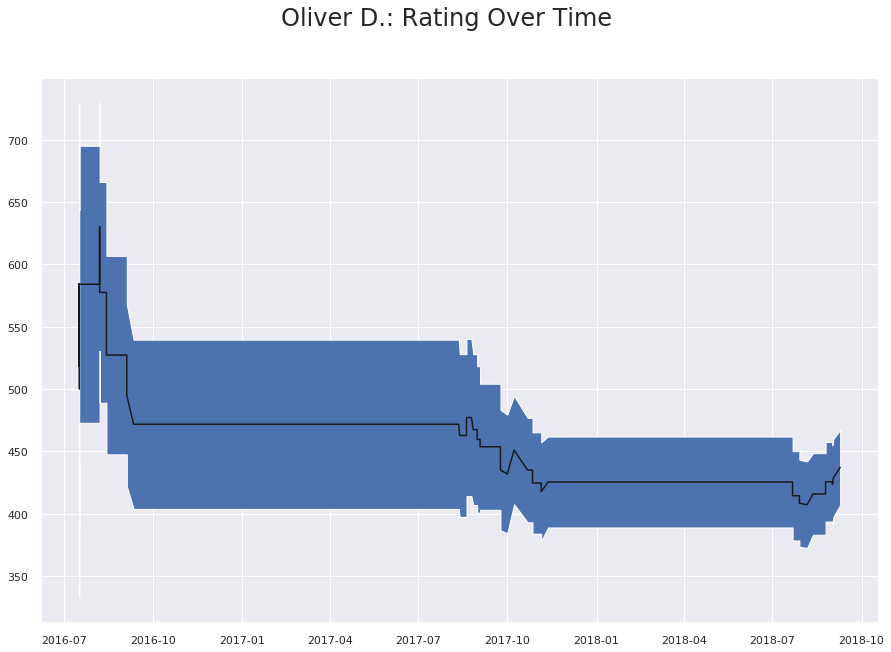

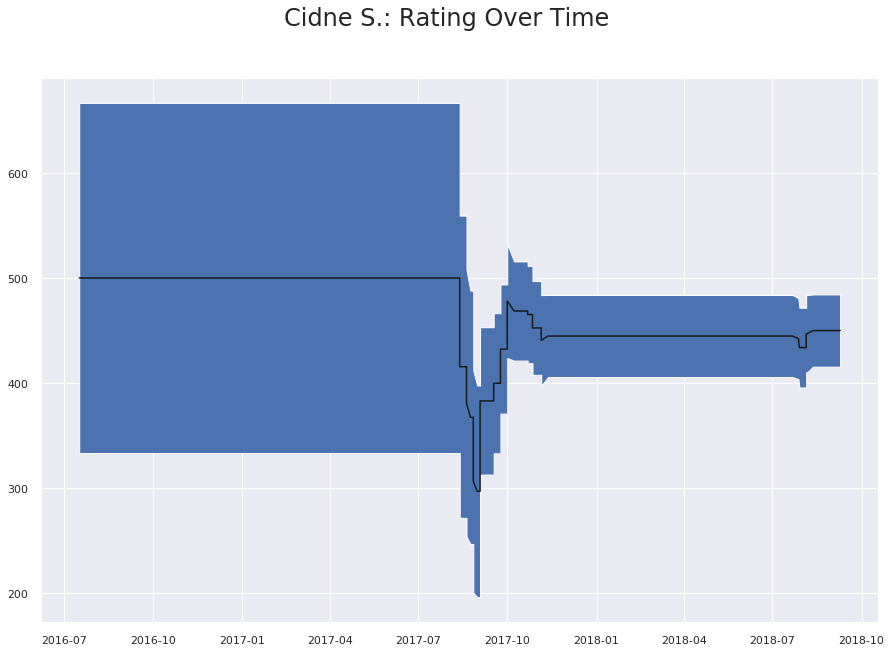

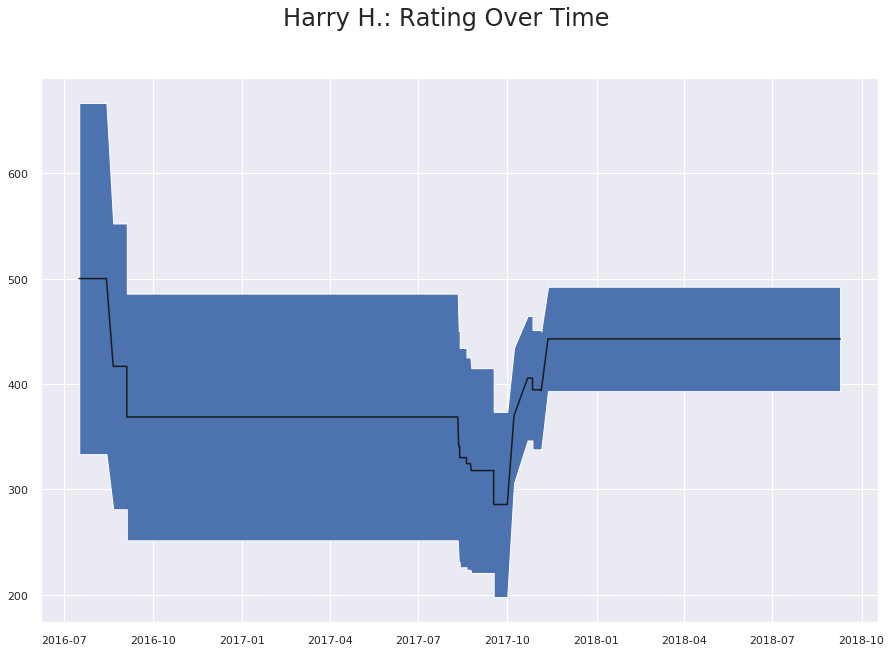

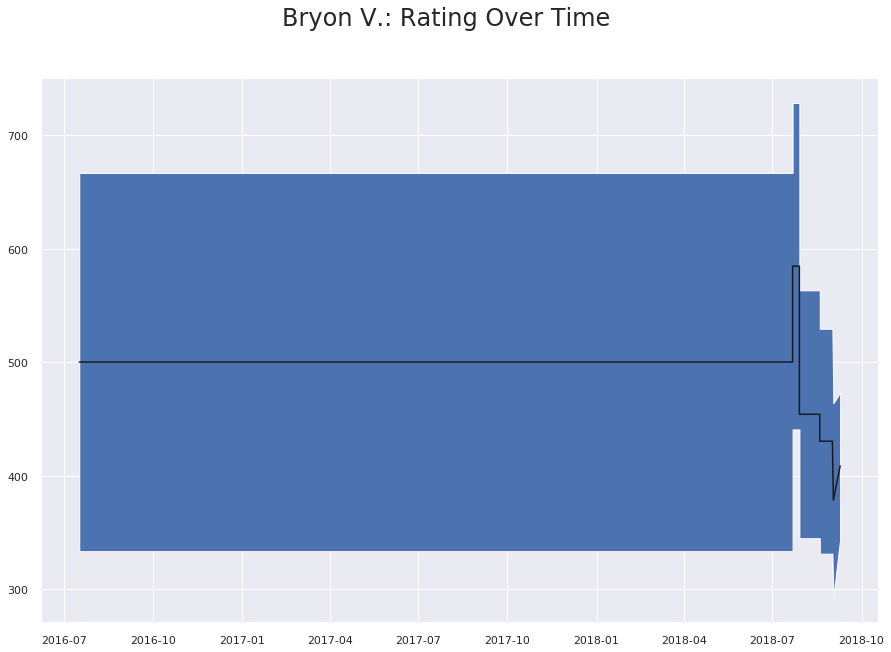

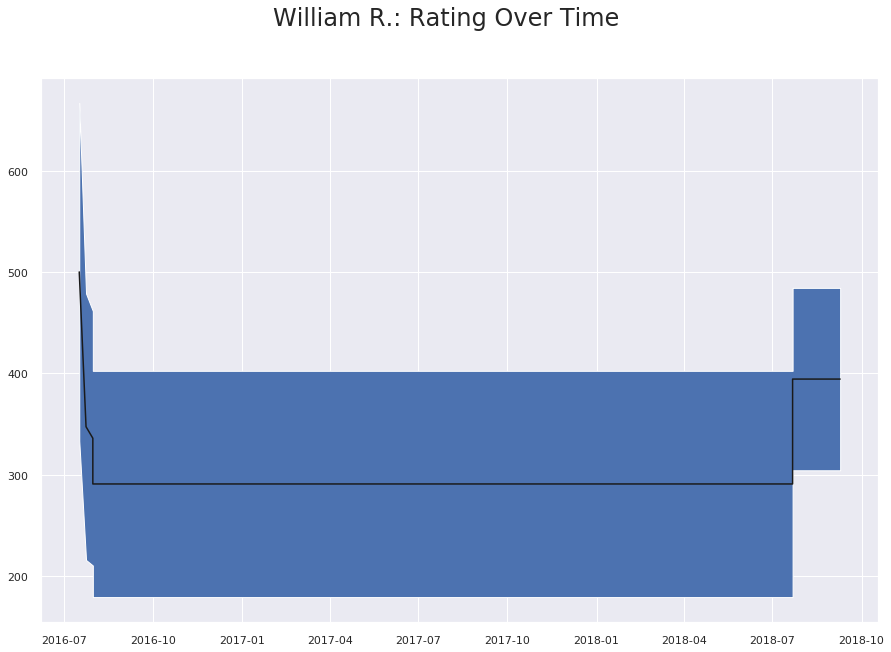

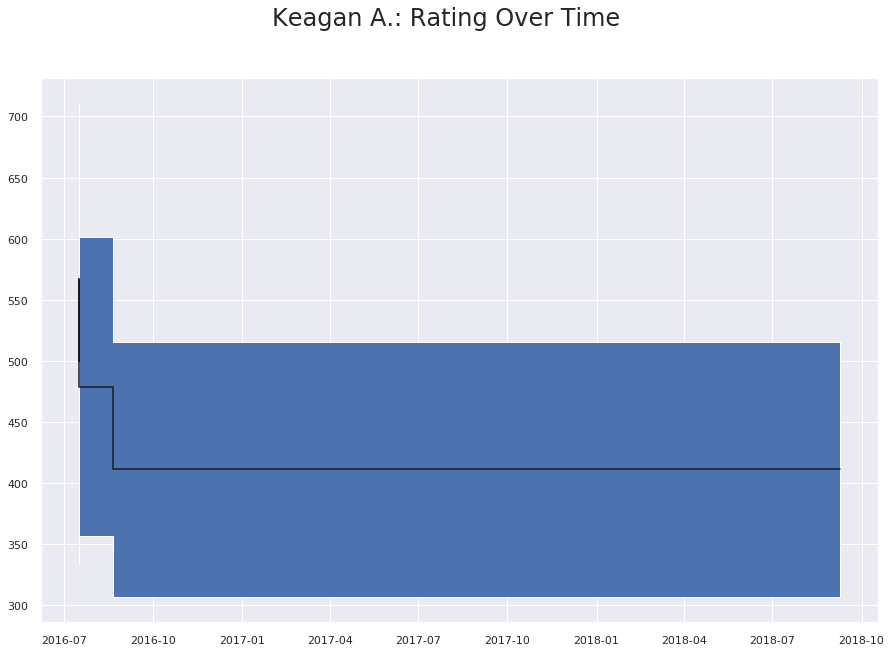

In [11]:
def plot_player(name, p):
    f = plt.figure(figsize=(15,10))
    f.suptitle('{}: Rating Over Time'.format(name), fontsize=24)
    plt.plot_date(gamedates, [r.mu for r in p], 'k-', label='Hi')
    plt.fill_between(gamedates, [r.mu - r.sigma for r in p], [r.mu + r.sigma for r in p])
    
for n, r, m in sorted_ratings:
    plot_player(n, [r[n] for _, _, r in postgame_ratings])